# Annotation Report


This is an automatic report generated from a set of annotations compared to a gold standard.
It is recommended to install https://github.com/kirbs-/hide_code to get a cleaner report

### Usage

The generation has two steps: running the ipython notebook and exporting the result into an html file. The annotation files must be specified as environment variables 

To run, 

`GOLD_STANDARD_FILENAME='gold_standard_path' ANNOTION_FILENAME='annotation_path' jupyter nbconvert --to notebook --execute Report.ipynb`

To export,

`jupyter nbconvert --to hide_code_html Report.ipynb`


In [30]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')

from imp import reload
import read_annotations
reload(read_annotations);

import show_metrics
reload(show_metrics);

In [3]:
GOLD_STANDARD = !echo "$GOLD_STANDARD_FILENAME"
ANNOTATION_FILE = !echo "$ANNOTION_FILENAME"
if GOLD_STANDARD[0] == '':
    GOLD_STANDARD = '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-cristian/CASE_OF__ALKASI_v._TURKEY.txt'
else:
    GOLD_STANDARD = GOLD_STANDARD[0]
if ANNOTATION_FILE[0] == '':
    ANNOTATION_FILE = '/home/milagro/am/third_party/brat-v1.3_Crunchy_Frog/data/judgements-laura/CASE_OF__ALKASI_v._TURKEY.txt'
else:
    ANNOTATION_FILE = ANNOTATION_FILE[0]

In [5]:
documents = read_annotations.read_parallel_annotations([('ann1', ANNOTATION_FILE), ('gold', GOLD_STANDARD)])
annotation = documents['ann1']
gold = documents['gold']

## Kappa agreement with gold standard

Kappa agreement using the full set of labels (claim, major-claim, premise, O)

Kohen-'s Kappa Ann: G - Ann: A: 0.541169831921926
Observed Agreement: 70.58%


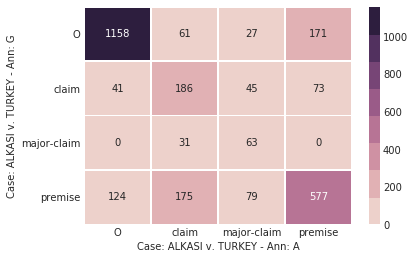

In [7]:
labels1, labels2 = read_annotations.get_labels(gold, annotation)
show_metrics.show_kappa(labels1, labels2, gold.identifier, annotation.identifier)
show_metrics.show_confusion_matrix(labels1, labels2, gold.identifier, annotation.identifier)

Kappa agreement using the only the labels claim, premise and O

Kohen-'s Kappa Ann: G - Ann: A: 0.5735369872743559
Observed Agreement: 73.28%


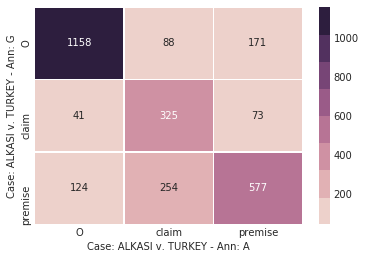

In [29]:
def get_simplified_labels(labels):
    return [x if x != 'major-claim' else 'claim' for x in labels]
labels1, labels2 = read_annotations.get_labels(gold, annotation)
labels1 = get_simplified_labels(labels1)
labels2 = get_simplified_labels(labels2)
show_metrics.show_kappa(labels1, labels2, gold.identifier, annotation.identifier)
show_metrics.show_confusion_matrix(labels1, labels2, gold.identifier, annotation.identifier)

In [12]:
STYLES = {'claim': 'red', 'premise': 'green', 'major-claim': 'blue'}

## TYPE 1: Span errors

The following components where correctly identified, but the span is not matching. It's possible they can be solved easily.

In [20]:
def similar_components(doc1, doc2, name1='A', name2='G', tolerance=0.5):
    """Samples sentences where the components share al least tolerance words.
    """
    for sentence1, sentence2 in zip(doc1.sentences, doc2.sentences):
        mismatching_words = sum(1 for i, j in zip(sentence1.labels, sentence2.labels) if i != j)
        labeled_words = max(
            len([i for i in sentence1.labels if i != doc1.default_label]),
            len([i for i in sentence2.labels if i != doc2.default_label]))
        if mismatching_words == 0 or mismatching_words > labeled_words * tolerance:
            continue
        # Print both sentences
        print(name1 + ': ' + sentence1.pretty_print(styles=STYLES))
        print(name2 + ': ' + sentence2.pretty_print(styles=STYLES))
        print('---')

In [21]:
similar_components(annotation, gold)

A: Being the master of the characterisation to be given in law to the facts of the case , the Court considers that {the applicant ’ s grievances fall to be examined solely under Article 6 § 2 of the Convention which reads as follows : }
G: Being the master of the characterisation to be given in law to the facts of the case , the Court considers that {the applicant ’ s grievances fall to be examined solely under Article 6 § 2 of the Convention }which reads as follows : 
---
A: {Although she had retracted her statements at a later date and denied having committed the alleged offence , the labour court had established that the acts of the applicant had breached her employer ’ s trust and therefore justified her dismissal from her post . }
G: Although {she had retracted her statements at a later date and denied having committed the alleged offence , the labour court had established that the acts of the applicant had breached her employer ’ s trust and therefore justified her dismissal from

## TYPE 2: Unindentified components

In [26]:
def unlabeled_components(doc1, doc2, name1='A', name2='G'):
    """Samples sentences where the components in doc2 are not labeled in doc1 or viceversa."""
    for sentence1, sentence2 in zip(doc1.sentences, doc2.sentences):
        mismatching_words = sum(1 for i, j in zip(sentence1.labels, sentence2.labels)
                                if i != j and (i == doc1.default_label or j == doc2.default_label))
        matching_words = sum(1 for i, j in zip(sentence1.labels, sentence2.labels) if i == j)
        if mismatching_words == 0 or matching_words > 0:
            continue
        # Print both sentences
        print(name1 + ': ' + sentence1.pretty_print(styles=STYLES))
        print(name2 + ': ' + sentence2.pretty_print(styles=STYLES))
        print('---')

In [25]:
unlabeled_components(annotation, gold)

A: {“ Everyone charged with a criminal offence shall be presumed innocent until proved guilty according to law . ” }
G: “ {Everyone charged with a criminal offence shall be presumed innocent until proved guilty according to law . }” 
---
A: {Its general aim , in this second aspect , is to protect individuals who have been acquitted of a criminal charge , or in respect of whom criminal proceedings have been discontinued , from being treated by public officials and authorities as though they are in fact guilty of the offence charged . }
G: Its general aim , in this second aspect , is to {protect individuals who have been acquitted of a criminal charge , or in respect of whom criminal proceedings have been discontinued , from being treated by public officials and authorities as though they are in fact guilty of the offence charged . }
---
A: {Without protection to ensure respect for the acquittal or the discontinuation decision in any other proceedings , the fair trial guarantees of Artic

## Type 3: Mislabeled components

The label of the component was incorrect.

In [27]:
def misslabeled_components(doc1, doc2, name1='A', name2='G', tolerance=0.5):
    """Samples sentences where the component label in doc2 does not match with the label in doc1,
    but both are labeled."""
    for sentence1, sentence2 in zip(doc1.sentences, doc2.sentences):
        mismatching_words = sum(1 for i, j in zip(sentence1.labels, sentence2.labels)
                                if i != j and i != doc1.default_label and j != doc2.default_label)
        labeled_words = max(
            len([i for i in sentence1.labels if i != doc1.default_label]),
            len([i for i in sentence2.labels if i != doc2.default_label]))
        if mismatching_words == 0:
            continue
        # Print both sentences
        print(name1 + ': ' + sentence1.pretty_print(styles=STYLES))
        print(name2 + ': ' + sentence2.pretty_print(styles=STYLES))
        print('---')

In [28]:
misslabeled_components(annotation, gold)

A: {Relying on Article 6 of the Convention , }the applicant complains that {the labour court ’ s dismissal of her claim for compensation against her former employer amounted to a violation of her right to be presumed innocent , }in that {the labour court found that she had broken her employer ’ s trust by committing the offence of incitement . }
G: Relying on {Article 6 of the Convention , }the applicant complains that {the labour court ’ s dismissal of her claim for compensation against her former employer amounted to a violation of her right to be presumed innocent , }in that {the labour court found that she had broken her employer ’ s trust by committing the offence of incitement . }
---
A: The applicant argues that {the labour court ’ s complete disregard of her acquittal in relation to the charge of incitement is incompatible with the requirements of Article 6 § 2 of the Convention . }
G: The applicant argues that {the labour court ’ s complete disregard of her acquittal in relati